# Notebook 04: ARIMAX Test Configurations

**Purpose:** Test 6-8 CORE features in three ARIMAX configurations

**Configurations:**
1. **Original ARIMAX:** SARIMAX(2,0,1)×(1,0,1,12) + exog (current failing config)
2. **Simplified ARIMAX:** SARIMAX(1,0,1)×(0,0,0,0) + exog (no seasonal)
3. **Pure ARIMA:** SARIMAX(1,0,1)×(0,0,0,0) no exog (baseline)

**Objective:** Determine if reducing to 6-8 features fixes overfitting

**Success Criteria:** Validation R² > 0.0 (better than predicting mean)

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Data

In [2]:
# Load CORE features (6-8 features per route)
p1a_core = pd.read_csv('data/processed/features/p1a_core_features_final_v2.csv',
                       index_col='Date', parse_dates=True)
p3a_core = pd.read_csv('data/processed/features/p3a_core_features_final_v2.csv',
                       index_col='Date', parse_dates=True)

# Load labels
labels = pd.read_csv('data/processed/intermediate/labels.csv',
                     index_col='Date', parse_dates=True)

print(f"Data loaded:")
print(f"  P1A CORE: {p1a_core.shape[1]} features x {len(p1a_core)} rows")
print(f"  P3A CORE: {p3a_core.shape[1]} features x {len(p3a_core)} rows")
print(f"  Labels:   {labels.shape}")

print(f"\nP1A CORE features:")
for i, feat in enumerate(p1a_core.columns, 1):
    print(f"  {i}. {feat}")

print(f"\nP3A CORE features:")
for i, feat in enumerate(p3a_core.columns, 1):
    print(f"  {i}. {feat}")

Data loaded:
  P1A CORE: 8 features x 1153 rows
  P3A CORE: 8 features x 1153 rows
  Labels:   (1153, 2)

P1A CORE features:
  1. Coal_Trade_Volume_Index_vol30
  2. Atlantic_IP_yoy
  3. Panamax_Orderbook_Pct_vol30
  4. PDOPEX_vol30
  5. MGO_yoy
  6. BPI_vol30
  7. Capesize_Orderbook_Pct_vol30
  8. C5TC_vol30

P3A CORE features:
  1. Panamax_Orderbook_Pct_vol30
  2. MGO_yoy
  3. Panamax_Fleet_Growth_YoY_vol30
  4. P4_82_yoy
  5. Panamax_Idle_Pct_vol30
  6. Capesize_Orderbook_Pct_vol30
  7. Atlantic_IP_yoy
  8. PDOPEX_vol30


## 2. Prepare Train/Validation/Test Split

In [3]:
# P1A
p1a_data = p1a_core.join(labels['P1A_82'], how='inner').dropna()

train_size = int(len(p1a_data) * 0.56)  # 56% train
val_size = int(len(p1a_data) * 0.14)    # 14% validation

p1a_train = p1a_data.iloc[:train_size]
p1a_val = p1a_data.iloc[train_size:train_size+val_size]
p1a_test = p1a_data.iloc[train_size+val_size:]

print(f"P1A splits:")
print(f"  Train:      {len(p1a_train)} rows ({len(p1a_train)/len(p1a_data)*100:.1f}%)")
print(f"  Validation: {len(p1a_val)} rows ({len(p1a_val)/len(p1a_data)*100:.1f}%)")
print(f"  Test:       {len(p1a_test)} rows ({len(p1a_test)/len(p1a_data)*100:.1f}%)")

# P3A
p3a_data = p3a_core.join(labels['P3A_82'], how='inner').dropna()

train_size = int(len(p3a_data) * 0.56)
val_size = int(len(p3a_data) * 0.14)

p3a_train = p3a_data.iloc[:train_size]
p3a_val = p3a_data.iloc[train_size:train_size+val_size]
p3a_test = p3a_data.iloc[train_size+val_size:]

print(f"\nP3A splits:")
print(f"  Train:      {len(p3a_train)} rows ({len(p3a_train)/len(p3a_data)*100:.1f}%)")
print(f"  Validation: {len(p3a_val)} rows ({len(p3a_val)/len(p3a_data)*100:.1f}%)")
print(f"  Test:       {len(p3a_test)} rows ({len(p3a_test)/len(p3a_data)*100:.1f}%)")

P1A splits:
  Train:      628 rows (55.9%)
  Validation: 157 rows (14.0%)
  Test:       338 rows (30.1%)

P3A splits:
  Train:      628 rows (55.9%)
  Validation: 157 rows (14.0%)
  Test:       338 rows (30.1%)


## 3. ARIMAX Test Function

In [4]:
def test_arimax_config(y_train, X_train, y_val, X_val, 
                       order, seasonal_order, 
                       config_name, route_name):
    """
    Test ARIMAX configuration.
    
    Parameters:
    -----------
    y_train, X_train : Training data
    y_val, X_val : Validation data
    order : ARIMA(p,d,q) order
    seasonal_order : Seasonal ARIMA order
    config_name : Configuration identifier
    route_name : Route identifier
    
    Returns:
    --------
    results : dict with performance metrics
    """
    
    print(f"\n{'=' * 80}")
    print(f"{config_name}: {route_name}")
    print(f"{'=' * 80}")
    
    print(f"\nModel: SARIMAX{order} x {seasonal_order}")
    if X_train is not None:
        print(f"Exogenous features: {X_train.shape[1]}")
        n_params = sum(order[:2]) + order[2] + sum(seasonal_order[:2]) + seasonal_order[2] + X_train.shape[1] + 1
    else:
        print(f"Exogenous features: 0 (Pure ARIMA)")
        n_params = sum(order[:2]) + order[2] + sum(seasonal_order[:2]) + seasonal_order[2] + 1
    
    print(f"Estimated parameters: {n_params}")
    print(f"Training samples: {len(y_train)}")
    print(f"Obs/param ratio: {len(y_train)/n_params:.1f}")
    
    # Fit model
    try:
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False, maxiter=200, method='lbfgs')
        print(f"\n[OK] Model converged")
        
    except Exception as e:
        print(f"\n[FAIL] Model fitting failed: {str(e)}")
        return None
    
    # In-sample performance
    train_pred = results.fittedvalues
    train_r2 = r2_score(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    
    # Out-of-sample forecast
    try:
        val_forecast = results.forecast(steps=len(y_val), exog=X_val)
        val_r2 = r2_score(y_val, val_forecast)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_forecast))
        val_mae = mean_absolute_error(y_val, val_forecast)
        
        print(f"\n{'=' * 80}")
        print(f"PERFORMANCE")
        print(f"{'=' * 80}")
        print(f"\nTraining:")
        print(f"  R²:   {train_r2:7.4f}")
        print(f"  RMSE: {train_rmse:7.2f}")
        
        print(f"\nValidation:")
        print(f"  R²:   {val_r2:7.4f} {'[OK]' if val_r2 > 0 else '[FAIL]'}")
        print(f"  RMSE: {val_rmse:7.2f}")
        print(f"  MAE:  {val_mae:7.2f}")
        
        if val_r2 > 0:
            print(f"\n[OK] Validation R² > 0 (beats naive mean)")
        else:
            print(f"\n[FAIL] Validation R² < 0 (worse than naive mean)")
        
        overfitting_ratio = train_rmse / val_rmse
        if overfitting_ratio < 0.5:
            print(f"[WARN] Severe overfitting: Train RMSE / Val RMSE = {overfitting_ratio:.2f}")
        
    except Exception as e:
        print(f"\n[FAIL] Forecasting failed: {str(e)}")
        val_r2 = np.nan
        val_rmse = np.nan
        val_mae = np.nan
    
    # Diagnostics
    print(f"\n{'=' * 80}")
    print(f"DIAGNOSTICS")
    print(f"{'=' * 80}")
    
    print(f"\nModel Fit:")
    print(f"  AIC: {results.aic:.2f}")
    print(f"  BIC: {results.bic:.2f}")
    
    # Ljung-Box test
    try:
        lb_test = acorr_ljungbox(results.resid, lags=20, return_df=True)
        lb_min_p = lb_test['lb_pvalue'].min()
        
        if lb_min_p > 0.05:
            print(f"\nLjung-Box: [OK] No autocorrelation (p = {lb_min_p:.4f})")
        else:
            print(f"\nLjung-Box: [WARN] Autocorrelation detected (p = {lb_min_p:.4f})")
    except:
        print(f"\nLjung-Box: [FAIL] Test failed")
    
    # ARCH test
    try:
        arch_test = het_arch(results.resid, nlags=10)
        arch_p = arch_test[1]
        
        if arch_p < 0.05:
            print(f"ARCH test:  [WARN] ARCH effects detected (p = {arch_p:.4f}) -> GARCH recommended")
        else:
            print(f"ARCH test:  [OK] No ARCH effects (p = {arch_p:.4f})")
    except:
        print(f"ARCH test:  [FAIL] Test failed")
    
    return {
        'config': config_name,
        'route': route_name,
        'n_params': n_params,
        'n_exog': X_train.shape[1] if X_train is not None else 0,
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'val_r2': val_r2,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'aic': results.aic,
        'bic': results.bic
    }

print("Test function defined")

Test function defined


## 4. Test P1A Route

### 4.1 Configuration 1: Original ARIMAX (with seasonal)

In [5]:
p1a_config1 = test_arimax_config(
    y_train=p1a_train['P1A_82'],
    X_train=p1a_train[p1a_core.columns],
    y_val=p1a_val['P1A_82'],
    X_val=p1a_val[p1a_core.columns],
    order=(2, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    config_name="Config 1: Original ARIMAX",
    route_name="P1A"
)


Config 1: Original ARIMAX: P1A

Model: SARIMAX(2, 0, 1) x (1, 0, 1, 12)
Exogenous features: 8
Estimated parameters: 14
Training samples: 628
Obs/param ratio: 44.9


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[OK] Model converged

PERFORMANCE

Training:
  R²:    0.9953
  RMSE:  626.49

Validation:
  R²:   -2.5501 [FAIL]
  RMSE: 8739.13
  MAE:  7366.48

[FAIL] Validation R² < 0 (worse than naive mean)
[WARN] Severe overfitting: Train RMSE / Val RMSE = 0.07

DIAGNOSTICS

Model Fit:
  AIC: 9695.41
  BIC: 9757.29

Ljung-Box: [WARN] Autocorrelation detected (p = 0.0005)
ARCH test:  [WARN] ARCH effects detected (p = 0.0005) -> GARCH recommended


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 4.2 Configuration 2: Simplified ARIMAX (no seasonal)

In [6]:
p1a_config2 = test_arimax_config(
    y_train=p1a_train['P1A_82'],
    X_train=p1a_train[p1a_core.columns],
    y_val=p1a_val['P1A_82'],
    X_val=p1a_val[p1a_core.columns],
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),
    config_name="Config 2: Simplified ARIMAX",
    route_name="P1A"
)


Config 2: Simplified ARIMAX: P1A

Model: SARIMAX(1, 0, 1) x (0, 0, 0, 0)
Exogenous features: 8
Estimated parameters: 11
Training samples: 628
Obs/param ratio: 57.1


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[OK] Model converged

PERFORMANCE

Training:
  R²:    0.9941
  RMSE:  704.64

Validation:
  R²:   -2.2498 [FAIL]
  RMSE: 8361.35
  MAE:  6557.47

[FAIL] Validation R² < 0 (worse than naive mean)
[WARN] Severe overfitting: Train RMSE / Val RMSE = 0.08

DIAGNOSTICS

Model Fit:
  AIC: 9993.45
  BIC: 10042.28

Ljung-Box: [WARN] Autocorrelation detected (p = 0.0000)
ARCH test:  [WARN] ARCH effects detected (p = 0.0000) -> GARCH recommended


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 4.3 Configuration 3: Pure ARIMA (no exogenous)

In [7]:
p1a_config3 = test_arimax_config(
    y_train=p1a_train['P1A_82'],
    X_train=None,
    y_val=p1a_val['P1A_82'],
    X_val=None,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),
    config_name="Config 3: Pure ARIMA",
    route_name="P1A"
)


Config 3: Pure ARIMA: P1A

Model: SARIMAX(1, 0, 1) x (0, 0, 0, 0)
Exogenous features: 0 (Pure ARIMA)
Estimated parameters: 3
Training samples: 628
Obs/param ratio: 209.3

[OK] Model converged

PERFORMANCE

Training:
  R²:    0.9922
  RMSE:  806.77

Validation:
  R²:    0.1533 [OK]
  RMSE: 4267.92
  MAE:  3184.11

[OK] Validation R² > 0 (beats naive mean)
[WARN] Severe overfitting: Train RMSE / Val RMSE = 0.19

DIAGNOSTICS

Model Fit:
  AIC: 9805.71
  BIC: 9819.03

Ljung-Box: [WARN] Autocorrelation detected (p = 0.0000)
ARCH test:  [WARN] ARCH effects detected (p = 0.0000) -> GARCH recommended


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 5. Test P3A Route

### 5.1 Configuration 1: Original ARIMAX (with seasonal)

In [8]:
p3a_config1 = test_arimax_config(
    y_train=p3a_train['P3A_82'],
    X_train=p3a_train[p3a_core.columns],
    y_val=p3a_val['P3A_82'],
    X_val=p3a_val[p3a_core.columns],
    order=(2, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    config_name="Config 1: Original ARIMAX",
    route_name="P3A"
)

C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Config 1: Original ARIMAX: P3A

Model: SARIMAX(2, 0, 1) x (1, 0, 1, 12)
Exogenous features: 8
Estimated parameters: 14
Training samples: 628
Obs/param ratio: 44.9

[OK] Model converged

PERFORMANCE

Training:
  R²:    0.9790
  RMSE: 1254.77

Validation:
  R²:   -18.0757 [FAIL]
  RMSE: 10789.37
  MAE:  7841.16

[FAIL] Validation R² < 0 (worse than naive mean)
[WARN] Severe overfitting: Train RMSE / Val RMSE = 0.12

DIAGNOSTICS

Model Fit:
  AIC: 10076.49
  BIC: 10138.37

Ljung-Box: [WARN] Autocorrelation detected (p = 0.0000)
ARCH test:  [WARN] ARCH effects detected (p = 0.0000) -> GARCH recommended


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 5.2 Configuration 2: Simplified ARIMAX (no seasonal)

In [9]:
p3a_config2 = test_arimax_config(
    y_train=p3a_train['P3A_82'],
    X_train=p3a_train[p3a_core.columns],
    y_val=p3a_val['P3A_82'],
    X_val=p3a_val[p3a_core.columns],
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),
    config_name="Config 2: Simplified ARIMAX",
    route_name="P3A"
)


Config 2: Simplified ARIMAX: P3A

Model: SARIMAX(1, 0, 1) x (0, 0, 0, 0)
Exogenous features: 8
Estimated parameters: 11
Training samples: 628
Obs/param ratio: 57.1


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[OK] Model converged

PERFORMANCE

Training:
  R²:    0.9913
  RMSE:  807.85

Validation:
  R²:   -14.8592 [FAIL]
  RMSE: 9837.77
  MAE:  8286.34

[FAIL] Validation R² < 0 (worse than naive mean)
[WARN] Severe overfitting: Train RMSE / Val RMSE = 0.08

DIAGNOSTICS

Model Fit:
  AIC: 10078.83
  BIC: 10127.66

Ljung-Box: [WARN] Autocorrelation detected (p = 0.0000)
ARCH test:  [WARN] ARCH effects detected (p = 0.0000) -> GARCH recommended


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 5.3 Configuration 3: Pure ARIMA (no exogenous)

In [10]:
p3a_config3 = test_arimax_config(
    y_train=p3a_train['P3A_82'],
    X_train=None,
    y_val=p3a_val['P3A_82'],
    X_val=None,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),
    config_name="Config 3: Pure ARIMA",
    route_name="P3A"
)


Config 3: Pure ARIMA: P3A

Model: SARIMAX(1, 0, 1) x (0, 0, 0, 0)
Exogenous features: 0 (Pure ARIMA)
Estimated parameters: 3
Training samples: 628
Obs/param ratio: 209.3

[OK] Model converged

PERFORMANCE

Training:
  R²:    0.9898
  RMSE:  871.91

Validation:
  R²:   -1.4449 [FAIL]
  RMSE: 3862.65
  MAE:  3105.53

[FAIL] Validation R² < 0 (worse than naive mean)
[WARN] Severe overfitting: Train RMSE / Val RMSE = 0.23

DIAGNOSTICS

Model Fit:
  AIC: 9356.14
  BIC: 9369.46

Ljung-Box: [WARN] Autocorrelation detected (p = 0.0000)
ARCH test:  [WARN] ARCH effects detected (p = 0.0000) -> GARCH recommended


C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\moame\anaconda3\envs\mscfe-capstone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 6. Summary Comparison

In [11]:
# Compile results
all_results = [p1a_config1, p1a_config2, p1a_config3,
               p3a_config1, p3a_config2, p3a_config3]

# Filter out None (failed configs)
all_results = [r for r in all_results if r is not None]

results_df = pd.DataFrame(all_results)

print("\n" + "=" * 80)
print("SUMMARY: ALL CONFIGURATIONS")
print("=" * 80)

print("\n" + results_df[['route', 'config', 'n_params', 'n_exog', 
                          'val_r2', 'val_rmse', 'aic']].to_string(index=False))

# Save results
results_df.to_csv('data/processed/features/arimax_test_results.csv', index=False)
print("\n[OK] Results saved: data/processed/features/arimax_test_results.csv")


SUMMARY: ALL CONFIGURATIONS

route                      config  n_params  n_exog     val_r2     val_rmse          aic
  P1A   Config 1: Original ARIMAX        14       8  -2.550070  8739.133821  9695.410058
  P1A Config 2: Simplified ARIMAX        11       8  -2.249772  8361.349535  9993.448469
  P1A        Config 3: Pure ARIMA         3       0   0.153296  4267.915912  9805.709398
  P3A   Config 1: Original ARIMAX        14       8 -18.075690 10789.370095 10076.485841
  P3A Config 2: Simplified ARIMAX        11       8 -14.859203  9837.769693 10078.829855
  P3A        Config 3: Pure ARIMA         3       0  -1.444891  3862.653135  9356.142210

[OK] Results saved: data/processed/features/arimax_test_results.csv


## 7. Visualization

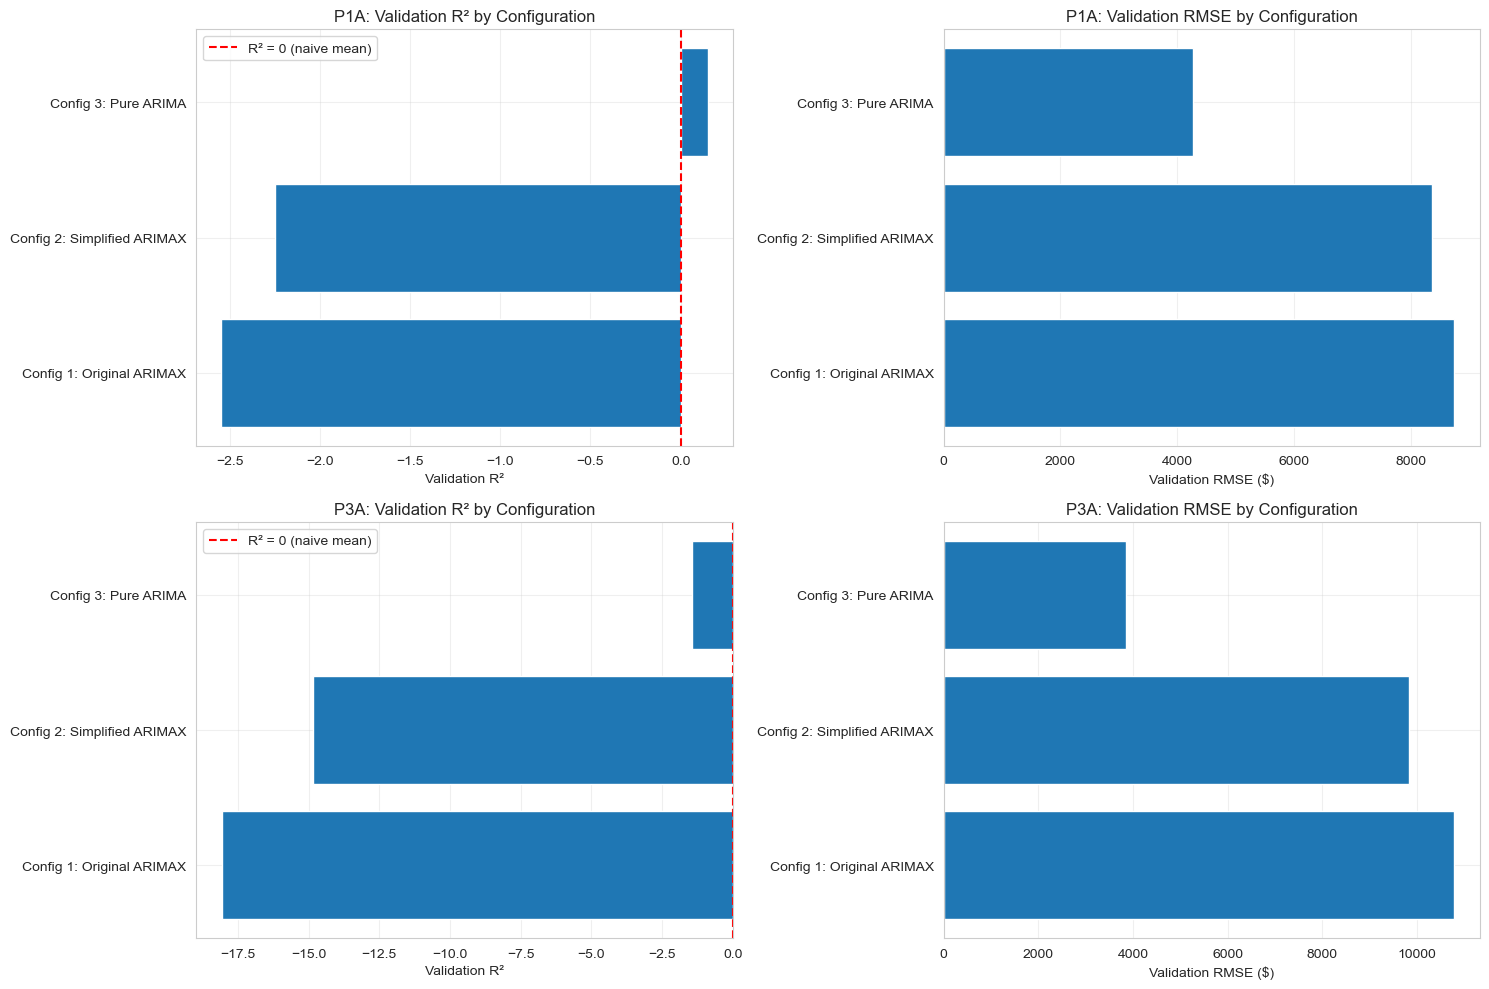


[OK] Visualization saved: data/processed/features/arimax_test_comparison.png


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# P1A Validation R²
p1a_results = results_df[results_df['route'] == 'P1A']
axes[0, 0].barh(p1a_results['config'], p1a_results['val_r2'])
axes[0, 0].axvline(0, color='red', linestyle='--', label='R² = 0 (naive mean)')
axes[0, 0].set_xlabel('Validation R²')
axes[0, 0].set_title('P1A: Validation R² by Configuration')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# P1A Validation RMSE
axes[0, 1].barh(p1a_results['config'], p1a_results['val_rmse'])
axes[0, 1].set_xlabel('Validation RMSE ($)')
axes[0, 1].set_title('P1A: Validation RMSE by Configuration')
axes[0, 1].grid(True, alpha=0.3)

# P3A Validation R²
p3a_results = results_df[results_df['route'] == 'P3A']
axes[1, 0].barh(p3a_results['config'], p3a_results['val_r2'])
axes[1, 0].axvline(0, color='red', linestyle='--', label='R² = 0 (naive mean)')
axes[1, 0].set_xlabel('Validation R²')
axes[1, 0].set_title('P3A: Validation R² by Configuration')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# P3A Validation RMSE
axes[1, 1].barh(p3a_results['config'], p3a_results['val_rmse'])
axes[1, 1].set_xlabel('Validation RMSE ($)')
axes[1, 1].set_title('P3A: Validation RMSE by Configuration')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/processed/features/arimax_test_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[OK] Visualization saved: data/processed/features/arimax_test_comparison.png")

## 8. Recommendation

In [13]:
print("\n" + "=" * 80)
print("RECOMMENDATION")
print("=" * 80)

# Find best config per route
p1a_best = p1a_results.loc[p1a_results['val_r2'].idxmax()]
p3a_best = p3a_results.loc[p3a_results['val_r2'].idxmax()]

print("\nP1A Best Configuration:")
print(f"  Config: {p1a_best['config']}")
print(f"  Val R²: {p1a_best['val_r2']:.4f}")
print(f"  Val RMSE: ${p1a_best['val_rmse']:.2f}")

if p1a_best['val_r2'] > 0:
    print(f"  [OK] Hybrid integration viable (R² > 0)")
else:
    print(f"  [WARN] Hybrid integration questionable (R² < 0)")

print("\nP3A Best Configuration:")
print(f"  Config: {p3a_best['config']}")
print(f"  Val R²: {p3a_best['val_r2']:.4f}")
print(f"  Val RMSE: ${p3a_best['val_rmse']:.2f}")

if p3a_best['val_r2'] > 0:
    print(f"  [OK] Hybrid integration viable (R² > 0)")
else:
    print(f"  [WARN] Hybrid integration questionable (R² < 0)")

print("\n" + "=" * 80)
print("NEXT STEPS BASED ON RESULTS")
print("=" * 80)

if p1a_best['val_r2'] > 0.3 and p3a_best['val_r2'] > 0.3:
    print("\n[OK] Both routes have strong validation R² > 0.3")
    print("  -> Proceed with hybrid integration (all 3 strategies viable)")
    print("  -> Use best config for each route in Notebook 05-06")

elif p1a_best['val_r2'] > 0 and p3a_best['val_r2'] > 0:
    print("\n[OK] Both routes have positive validation R² (weak but viable)")
    print("  -> Proceed with caution")
    print("  -> Use Sequential or Integrated hybrid (not Parallel)")
    print("  -> Acknowledge ARIMAX provides weak signal")

elif p1a_best['n_exog'] == 0 or p3a_best['n_exog'] == 0:
    print("\n[WARN] Pure ARIMA (no exog) performs best")
    print("  -> Exogenous features are not helpful")
    print("  -> Use Pure ARIMA + XGBoost hybrid (decompose-forecast-recombine)")
    print("  -> This is academically STRONG (Prophet-like approach)")

else:
    print("\n[FAIL] All configurations have R² < 0")
    print("  -> ARIMAX fundamentally unsuitable for this data")
    print("  -> Consider alternatives: VAR, VECM, GAM, or pure XGBoost")
    print("  -> Test cointegration (P1A, P3A, BPI) for VECM viability")

print("\n" + "=" * 80)
print("TEST COMPLETE")
print("=" * 80)


RECOMMENDATION

P1A Best Configuration:
  Config: Config 3: Pure ARIMA
  Val R²: 0.1533
  Val RMSE: $4267.92
  [OK] Hybrid integration viable (R² > 0)

P3A Best Configuration:
  Config: Config 3: Pure ARIMA
  Val R²: -1.4449
  Val RMSE: $3862.65
  [WARN] Hybrid integration questionable (R² < 0)

NEXT STEPS BASED ON RESULTS

[WARN] Pure ARIMA (no exog) performs best
  -> Exogenous features are not helpful
  -> Use Pure ARIMA + XGBoost hybrid (decompose-forecast-recombine)
  -> This is academically STRONG (Prophet-like approach)

TEST COMPLETE
